<a href="https://colab.research.google.com/github/smwhite24/Market_Crash_Predictor/blob/main/RandomForest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Import necessary libraries
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, to_date
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.classification import RandomForestClassifier
from pyspark.mllib.evaluation import MulticlassMetrics
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.classification import LogisticRegression

In [3]:
from google.colab import files
uploaded = files.upload()


Saving standardized_market_data (1).csv to standardized_market_data (1).csv
Saving spstandardized.csv to spstandardized.csv


In [4]:
from pyspark.sql import SparkSession

# Create a Spark session
spark = SparkSession.builder \
    .appName("RandomForestExample") \
    .getOrCreate()

# Load the CSV files into DataFrames
standardized_market_data_df = spark.read.csv('standardized_market_data (1).csv', header=True, inferSchema=True)
spstandardized_df = spark.read.csv('spstandardized.csv', header=True, inferSchema=True)

# Show the first few rows of the DataFrames (optional)
standardized_market_data_df.show(5)
spstandardized_df.show(5)

+----------+------------------+-----------------+--------+----------------+
|      Date|Federal Funds Rate|Unemployment Rate|     GDP|  Inflation Rate|
+----------+------------------+-----------------+--------+----------------+
|1975-01-01|              3.87|              8.1|1616.116|9.14314686496535|
|1975-02-01|              6.76|              8.1|1616.116|9.14314686496535|
|1975-03-01|              6.07|              8.6|1616.116|9.14314686496535|
|1975-04-01|              5.48|              8.8|1651.853|9.14314686496535|
|1975-05-01|              5.55|              9.0|1651.853|9.14314686496535|
+----------+------------------+-----------------+--------+----------------+
only showing top 5 rows

+---+----------+-----------------+
|_c0|      date|            Close|
+---+----------+-----------------+
|565|1975-01-01|72.56409107555042|
|566|1975-02-01|80.09684191252056|
|567|1975-03-01|83.83199920654297|
|568|1975-04-01|84.72318198464133|
|569|1975-05-01|90.09619031633648|
+---+------

In [5]:
# Rename the 'Date' column to 'date' in the second DataFrame
spstandardized_df = spstandardized_df.withColumnRenamed("date", "Date")

spstandardized_df.show(5)

+---+----------+-----------------+
|_c0|      Date|            Close|
+---+----------+-----------------+
|565|1975-01-01|72.56409107555042|
|566|1975-02-01|80.09684191252056|
|567|1975-03-01|83.83199920654297|
|568|1975-04-01|84.72318198464133|
|569|1975-05-01|90.09619031633648|
+---+----------+-----------------+
only showing top 5 rows



In [29]:
# Join the DataFrames on the 'date' column
merged_df = standardized_market_data_df.join(spstandardized_df, on='Date', how='inner')

merged_df.show(5)

+----------+------------------+-----------------+--------+----------------+---+-----------------+
|      Date|Federal Funds Rate|Unemployment Rate|     GDP|  Inflation Rate|_c0|            Close|
+----------+------------------+-----------------+--------+----------------+---+-----------------+
|1975-01-01|              3.87|              8.1|1616.116|9.14314686496535|565|72.56409107555042|
|1975-02-01|              6.76|              8.1|1616.116|9.14314686496535|566|80.09684191252056|
|1975-03-01|              6.07|              8.6|1616.116|9.14314686496535|567|83.83199920654297|
|1975-04-01|              5.48|              8.8|1651.853|9.14314686496535|568|84.72318198464133|
|1975-05-01|              5.55|              9.0|1651.853|9.14314686496535|569|90.09619031633648|
+----------+------------------+-----------------+--------+----------------+---+-----------------+
only showing top 5 rows



In [30]:
# Drop the original 'Date' column if you don't need it
merged_df = merged_df.drop("Date", "_c0")

merged_df.show(5)

+------------------+-----------------+--------+----------------+-----------------+
|Federal Funds Rate|Unemployment Rate|     GDP|  Inflation Rate|            Close|
+------------------+-----------------+--------+----------------+-----------------+
|              3.87|              8.1|1616.116|9.14314686496535|72.56409107555042|
|              6.76|              8.1|1616.116|9.14314686496535|80.09684191252056|
|              6.07|              8.6|1616.116|9.14314686496535|83.83199920654297|
|              5.48|              8.8|1651.853|9.14314686496535|84.72318198464133|
|              5.55|              9.0|1651.853|9.14314686496535|90.09619031633648|
+------------------+-----------------+--------+----------------+-----------------+
only showing top 5 rows



In [31]:
# Separate features (X) and labels (y)
y = merged_df.select('Close')
X = merged_df.drop('Close')

In [32]:
# Convert the label to a binary classification
threshold = 100
merged_df = merged_df.withColumn("label", (merged_df["Close"] > threshold).cast("integer"))

In [33]:
# Drop the 'Close' column after creating the label
merged_df = merged_df.drop("Close")

In [34]:
# Split the dataset into training and testing sets
train_df, test_df = merged_df.randomSplit([0.8, 0.2], seed=78)

In [35]:
# Use VectorAssembler to combine feature columns into a single feature vector for training data
feature_columns = [col for col in merged_df.columns if col != 'label']  # Get the feature column names excluding label
assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")

In [36]:
# Transform the training data
train_assembled = assembler.transform(train_df)

In [37]:
# Initialize RandomForestClassifier
rf = RandomForestClassifier(featuresCol="features", labelCol="label")

In [38]:
# Fit the model on the training data
rf_model = rf.fit(train_assembled)

# Transform the test data
test_assembled = assembler.transform(test_df)

# Make predictions
predictions = rf_model.transform(test_assembled)

In [42]:
# Evaluate Precision
# evaluator_precision = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="weightedPrecision")
# precision = evaluator_precision.evaluate(predictions)
# print(f"Weighted Precision: {precision}")

# # Evaluate Recall
# evaluator_recall = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="weightedRecall")
# recall = evaluator_recall.evaluate(predictions)
# print(f"Weighted Recall: {recall}")

# # Evaluate F1 Score
# evaluator_f1 = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="f1")
# f1_score = evaluator_f1.evaluate(predictions)
# print(f"F1 Score: {f1_score}")

evaluator_precision = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="weightedPrecision")
precision = evaluator_precision.evaluate(predictions)
print(f"Weighted Precision: {precision}")

evaluator_recall = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="weightedRecall")
recall = evaluator_recall.evaluate(predictions)
print(f"Weighted Recall: {recall}")

evaluator_f1 = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="f1")
f1_score = evaluator_f1.evaluate(predictions)
print(f"F1 Score: {f1_score}")

Weighted Precision: 0.9848484848484849
Weighted Recall: 0.9848484848484849
F1 Score: 0.9848484848484849


In [40]:
# Get feature importance
feature_importances = rf_model.featureImportances
print("Feature Importances:")
for feature, importance in zip(feature_columns, feature_importances):
    print(f"{feature}: {importance}")

Feature Importances:
Federal Funds Rate: 0.0821873590063346
Unemployment Rate: 0.15383883793990158
GDP: 0.5064181899613317
Inflation Rate: 0.2575556130924322


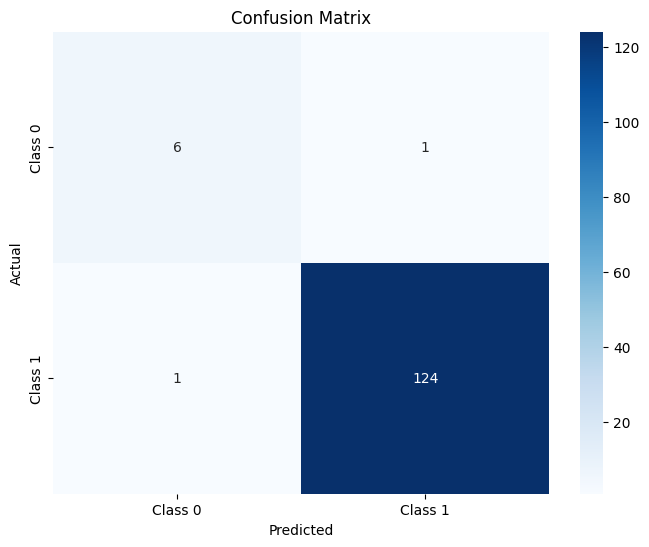

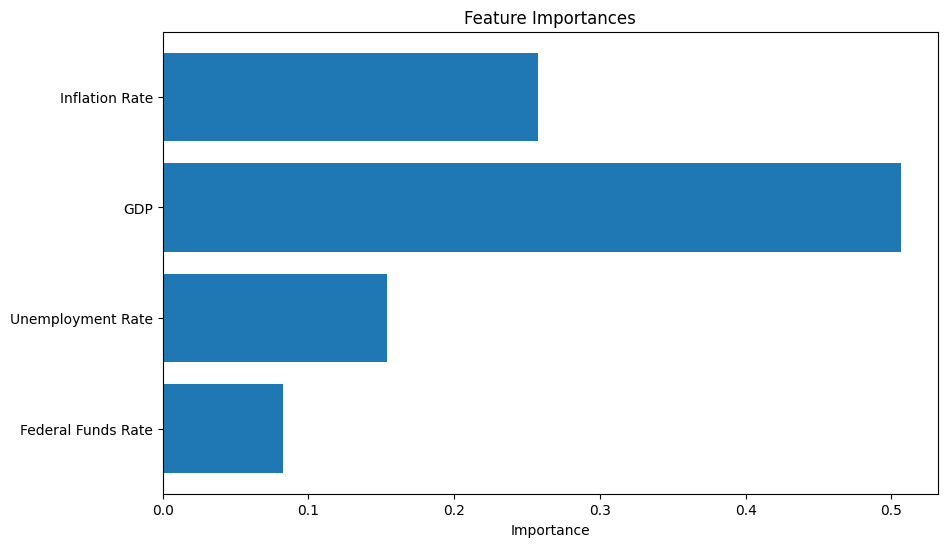

In [41]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Convert predictions to Pandas DataFrame for easier manipulation
predictions_pd = predictions.select("label", "prediction").toPandas()

# Create confusion matrix
cm = confusion_matrix(predictions_pd['label'], predictions_pd['prediction'])

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

# Plot feature importances
plt.figure(figsize=(10, 6))
plt.barh(feature_columns, feature_importances)
plt.xlabel('Importance')
plt.title('Feature Importances')
plt.show()